 This notebook covers relaxation methods for solving sparse linear systems. We'll go through Jacobi, Gauss-Seidel, and Successive Overrelaxation (SOR) methods.

Iterative methods are a category of algorithms used to solve sparse linear systems of equations. These methods are particularly useful for large systems where direct methods like LU decomposition become computationally expensive. The idea behind iterative methods is to start with an initial guess to the solution and iteratively refine this guess to get closer to the actual solution.

# 1. Jacobi Method

The Jacobi method is an iterative algorithm for solving the linear equation system of the form $Ax=b$. The method assumes that the matrix $A$ is decomposable into a diagonal matrix $D$, and the remainder $R$, such that $A=D+R$.

Algorithm:

1. Initialize an arbitrary guess $x^{(0)}$.
2. Update \(x\) using the formula $x_i^{(k+1)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j \neq i} a_{ij} x_j^{(k)} \right)$, where $k$ is the iteration step.
3. Repeat step 2 until convergence.




In [1]:
from scipy.sparse import diags, eye, kron


In [2]:
import numpy as np
from scipy.sparse import csr_matrix

def jacobi_inefficient(A, b, tolerance=1e-10, max_iterations=1000):

    x = np.zeros_like(b, dtype=np.double)
    n = A.shape[0]
    convergence = []

    for _ in range(max_iterations):
        x_new = np.zeros_like(x, dtype=np.double)
        for i in range(n):
            # Summation over all elements except the diagonal
            sum_ = 0
            for j in range(n):
                if i != j:
                    sum_ += A[i, j] * x[j]

            # Jacobi update (inefficiently using individual element access in CSR)
            x_new[i] = (b[i] - sum_) / A[i, i]

        convergence.append(np.linalg.norm(A.dot(x_new) - b, ord=np.inf))

        if np.linalg.norm(x_new - x, ord=np.inf) < tolerance:
            break
        x = x_new

    return x, convergence


In [3]:
import numpy as np
from scipy.sparse import csr_matrix, diags

def jacobi_sparse(A, b, tolerance=1e-10, max_iterations=1000):

    x = np.zeros_like(b, dtype=np.double)
    D_inv = 1.0 / A.diagonal()
    R = A - diags(A.diagonal(), offsets=0, shape=A.shape, format='csr')

    convergence = []
    for _ in range(max_iterations):
        x_new = x + D_inv * (b - A@x)
        convergence.append(np.linalg.norm(A.dot(x_new) - b, ord=np.inf))

        if np.linalg.norm(x_new - x, ord=np.inf) < tolerance:
            break
        x = x_new

    return x, convergence


In [4]:
def tridiag(a, b, c, n):
    # Create a tridiagonal matrix
    return diags([a*np.ones(n-1), b*np.ones(n), c*np.ones(n-1)], [-1, 0, 1], format='csr')

def fd3d(nx, ny, nz, alpx, alpy, alpz, dshift):
    # Create tridiagonal matrices tx, ty, tz
    tx = tridiag(-1+alpx, 2, -1-alpx, nx)
    ty = tridiag(-1+alpy, 2, -1-alpy, ny)
    tz = tridiag(-1+alpz, 2, -1-alpz, nz)

    # Compute A using Kronecker products
    A = kron(eye(ny), tx) + kron(ty, eye(nx))
    if nz > 1:
        A = kron(eye(nz), A) + kron(tz, eye(nx*ny))

    # Subtract dshift times identity matrix from A
    A -= dshift * eye(nx*ny*nz)

    return A.tocsr()

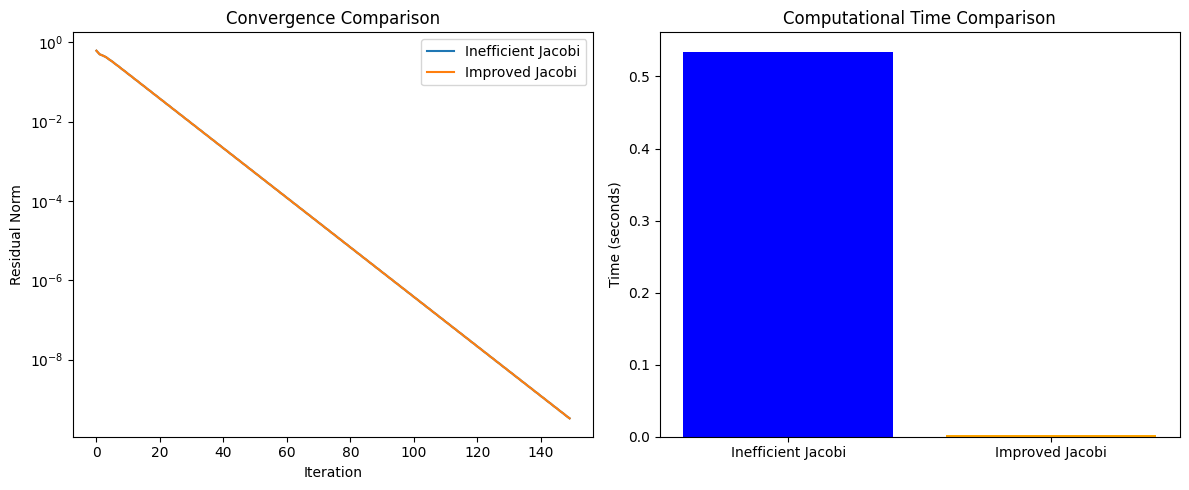

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define A and b
nx, ny, nz = 5, 5, 1
A = fd3d(nx,ny,nz,0,0,0,0)
b = np.random.random(nx*ny*nz).flatten()


# Solve using inefficient Jacobi
start_time_original= time.time()
_, convergence_original = jacobi_inefficient(A, b)
time_original = time.time() - start_time_original


# Solve using Improved Jacobi
start_time_improved = time.time()
_, convergence_improved = jacobi_sparse(A, b)
time_improved = time.time() - start_time_improved

# Plotting Convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(convergence_original,label='Inefficient Jacobi')
plt.semilogy(convergence_improved, label='Improved Jacobi')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.legend()

# Plotting Computational Time Comparison
plt.subplot(1, 2, 2)
bar_labels = ['Inefficient Jacobi', 'Improved Jacobi']
times = [time_original, time_improved]
plt.bar(bar_labels, times, color=['blue', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')

plt.tight_layout()
plt.show()


# 2. Gauss-Seidel Method

The Gauss-Seidel method is an iterative technique for solving a system of linear equations $Ax = b$. Similar to the Jacobi method, it aims to solve for the vector $x$ that satisfies this equation. However, unlike the Jacobi method which updates the solution vector all at once, the Gauss-Seidel method updates each entry of $x$ sequentially, immediately using the newly computed values in subsequent calculations within the same iteration. This can lead to faster convergence compared to the Jacobi method, especially for well-conditioned matrices.

Algorithm:

   

1.    Initialize an arbitrary guess $x^{(0)}$.
    
   
2.   Sequentially update each $x_i$ using the formula $x_i^{(k+1)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij} x_j^{(k)} \right)$, where $k$ is the iteration step. This formula reflects the immediate use of the latest available values of $x$.

3.  Repeat step 2 until the changes in $x$ between iterations are below a specified tolerance, indicating convergence.



The key difference in the Gauss-Seidel method compared to Jacobi is its use of the most recent values for the calculation of subsequent elements in the vector $x$ within the same iteration. This often results in faster convergence, but the method's performance can heavily depend on the ordering of the equations and the properties of the matrix $A$.
Implementations

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

def gauss_seidel_inefficient(A, b, tolerance=1e-10, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    n = A.shape[0]
    convergence = []

    for _ in range(max_iterations):
        x_old = x.copy()
        for i in range(n):
            sum_ = 0
            for j in range(n):
                if i != j:
                    sum_ += A[i, j] * x[j]
            x[i] = (b[i] - sum_) / A[i, i]

        convergence.append(np.linalg.norm(A.dot(x) - b, ord=np.inf))

        if np.linalg.norm(x - x_old, ord=np.inf) < tolerance:
            break

    return x, convergence


In [7]:
import numpy as np
from scipy.sparse import csr_matrix, tril, triu
from scipy.sparse.linalg import spsolve

def gauss_seidel_sparse(A, b, tolerance=1e-10, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    # Splitting A into its lower (L) and upper (U) components
    L = tril(A, format='csr')
    U = triu(A, k=1, format='csr')  # k=1 excludes the diagonal

    convergence = []
    for _ in range(max_iterations):
        x_old = x.copy()
        # Solving Lx = b - Ux iteratively
        # Note: spsolve assumes L is lower triangular and solves efficiently
        x = spsolve(L, b - U@x_old, use_umfpack=True)

        convergence.append(np.linalg.norm(A@x - b, ord=np.inf))
        if np.linalg.norm(x - x_old, ord=np.inf) < tolerance:
            break

    return x, convergence

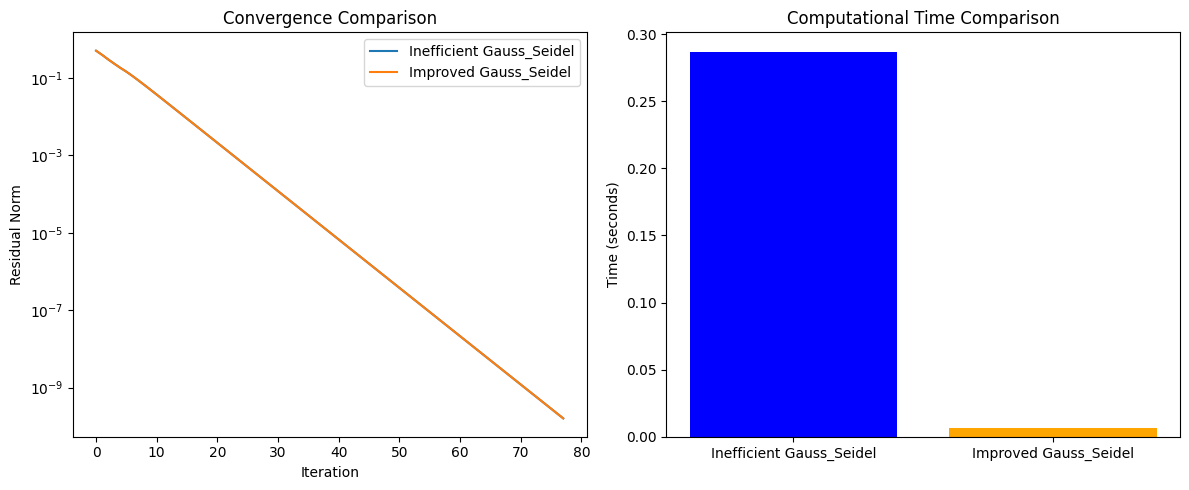

In [8]:
# Define A and b
nx, ny, nz = 5, 5, 1
A = fd3d(nx,ny,nz,0,0,0,0)
b = np.random.random(nx*ny*nz).flatten()


# Solve using inefficient gauss_seidel
start_time_original2= time.time()
_, convergence_original2 = gauss_seidel_inefficient(A, b)
time_original2 = time.time() - start_time_original2


# Solve using Improved Jacobi
start_time_improved2 = time.time()
_, convergence_improved2 = gauss_seidel_sparse(A, b)
time_improved2 = time.time() - start_time_improved2

# Plotting Convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(convergence_original2,label='Inefficient Gauss_Seidel')
plt.semilogy(convergence_improved2, label='Improved Gauss_Seidel')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.legend()

# Plotting Computational Time Comparison
plt.subplot(1, 2, 2)
bar_labels = ['Inefficient Gauss_Seidel', 'Improved Gauss_Seidel']
times = [time_original2, time_improved2]
plt.bar(bar_labels, times, color=['blue', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('Computational Time Comparison')

plt.tight_layout()
plt.show()


# Comparison between Jacobi and Gauss Seidel

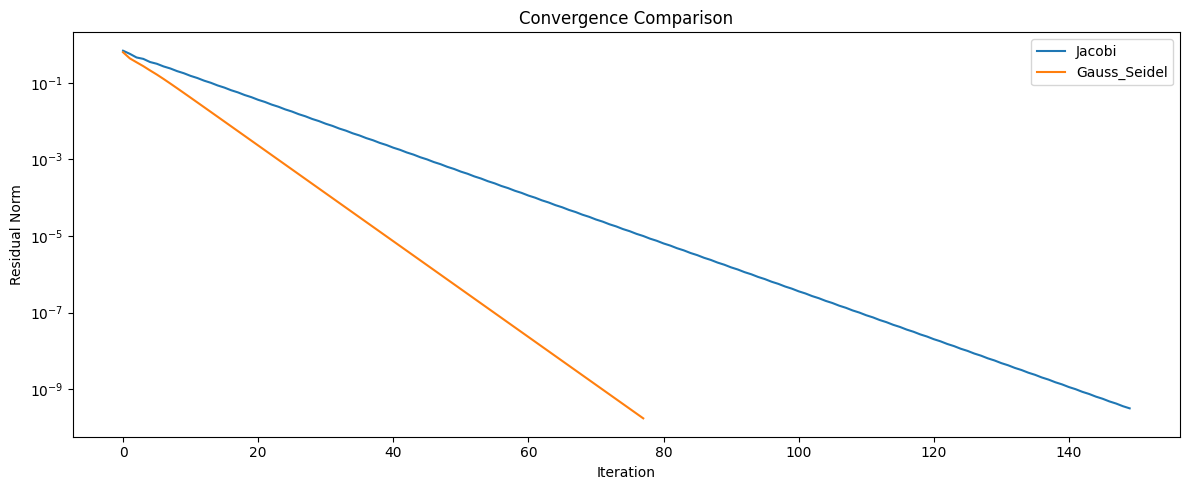

In [65]:
# Define A and b
nx, ny, nz = 5, 5, 1
A = fd3d(nx,ny,nz,0,0,0,0)
b = np.random.random(nx*ny*nz).flatten()


# Solve using Jacobi
start_time_jacobi= time.time()
_, convergence_jacobi = jacobi_sparse(A, b)
time_jacobi = time.time() - start_time_jacobi


# Solve using Improved Jacobi
start_time_gs = time.time()
_, convergence_gs = gauss_seidel_sparse(A, b)
time_gs = time.time() - start_time_gs

# Plotting Convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 1, 1)
plt.semilogy(convergence_jacobi,label='Jacobi')
plt.semilogy(convergence_gs, label='Gauss_Seidel')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.legend()



plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from scipy.sparse import csr_matrix, tril, triu
from scipy.sparse.linalg import spsolve

def sor_sparse(A, b, omega=1.1, tolerance=1e-10, max_iterations=1000):
    if not 0 < omega < 2:
        raise ValueError("Omega must be between 0 and 2 for convergence for SPD matrices.")

    x = np.zeros_like(b, dtype=np.double)
    n = A.shape[0]

    # Decompose A into its lower (L), diagonal (D), and upper (U) components
    D = diags(A.diagonal(), 0, format='csr')
    E = tril(A, k=-1)
    F = triu(A, k=1)

    convergence = []
    for iteration in range(max_iterations):
        x_old = x.copy()
        x = spsolve(D+omega*E, omega*b + (1-omega)*D@x_old - omega*F@x_old, use_umfpack=True)

        # Check for convergence
        convergence.append(np.linalg.norm(A.dot(x) - b, ord=np.inf))
        if np.linalg.norm(x - x_old, ord=np.inf) < tolerance:
            break

    return x, convergence


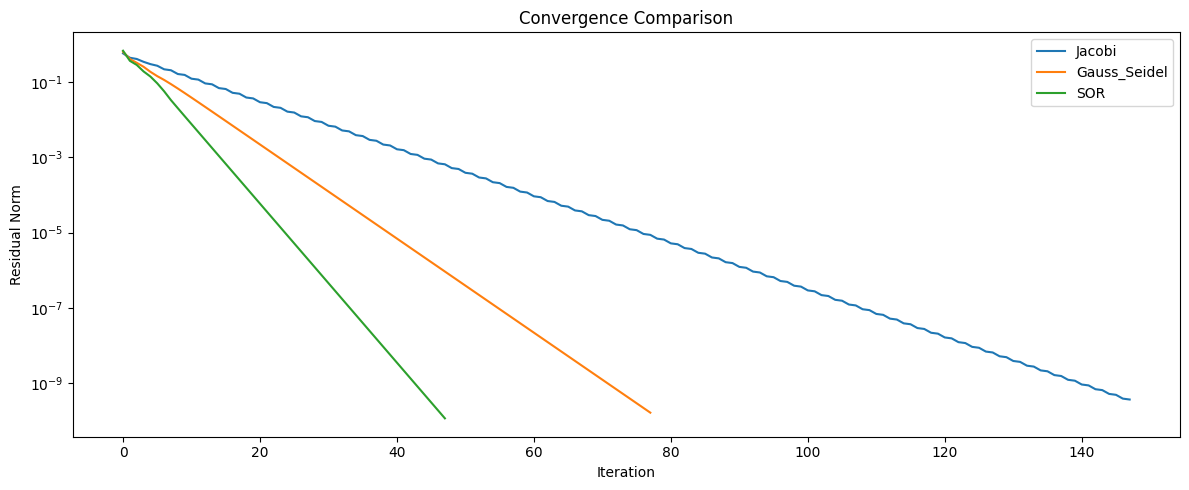

In [10]:
# Define A and b
nx, ny, nz = 5, 5, 1
A = fd3d(nx,ny,nz,0,0,0,0)
b = np.random.random(nx*ny*nz).flatten()


# Solve using Jacobi
start_time_jacobi= time.time()
_, convergence_jacobi = jacobi_sparse(A, b)
time_jacobi = time.time() - start_time_jacobi


# Solve using Improved Jacobi
start_time_gs = time.time()
_, convergence_gs = gauss_seidel_sparse(A, b)
time_gs = time.time() - start_time_gs


# Solve using SOR
start_time_sor = time.time()
_, convergence_sor = sor_sparse(A, b, 1.2)
time_gs = time.time() - start_time_sor


# Plotting Convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 1, 1)
plt.semilogy(convergence_jacobi,label='Jacobi')
plt.semilogy(convergence_gs, label='Gauss_Seidel')
plt.semilogy(convergence_sor, label='SOR')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.legend()



plt.tight_layout()
plt.show()